# Welcome to the GOAL Bioinformatics Bootcamp, 2025! To Setup this notebook please run the first cell. This will perform the needed downloads and setup to participate.

In [1]:
# NGS Bioinformatics Hands On Lab

# Install required packages
!apt-get update
!apt-get install -y fastp fastqc bwa samtools tabix
!pip install pysam

# Optional: Install additional tools if not available in Colab
!wget https://github.com/biod/sambamba/releases/download/v0.8.0/sambamba-0.8.0-linux-amd64-static.gz
!gunzip sambamba-0.8.0-linux-amd64-static.gz
!chmod +x sambamba-0.8.0-linux-amd64-static
!mv sambamba-0.8.0-linux-amd64-static /usr/local/bin/sambamba

# For ABRA2
!wget https://github.com/mozack/abra2/releases/download/v2.23/abra2-2.23.jar
!chmod +x abra2-2.23.jar

# For VarScan
!wget https://github.com/dkoboldt/varscan/raw/master/VarScan.v2.4.6.jar
!chmod +x VarScan.v2.4.6.jar

# for ANNOVAR
!wget http://www.openbioinformatics.org/annovar/download/0wgxR2rIVP/annovar.latest.tar.gz
!tar -zxvf annovar.latest.tar.gz
!rm -r annovar.latest.tar.gz
!rm -r annovar/humandb

# Create directories for data and reference files
!mkdir -p data assets/gatk_b37 assets/humandb annovar

# Download pre-indexed reference genome
!wget https://hgdownload.cse.ucsc.edu/goldenpath/hg19/bigZips/analysisSet/hg19.p13.plusMT.no_alt_analysis_set.bwa_index.tar.gz -O assets/hg19_bwa_index.tar.gz

# Extract BWA index files
!tar -xzvf /content/assets/hg19_bwa_index.tar.gz --strip-components=1 -C /content/assets/gatk_b37/

# Download reference FASTA file.
!wget https://hgdownload.cse.ucsc.edu/goldenpath/hg19/bigZips/analysisSet/hg19.p13.plusMT.no_alt_analysis_set.fa.gz -O /content/assets/gatk_b37/hg19.p13.plusMT.no_alt_analysis_set.fa.gz

# Uncompress the reference FASTA file
!gunzip -c /content/assets/gatk_b37/hg19.p13.plusMT.no_alt_analysis_set.fa.gz > /content/assets/gatk_b37/hg19.p13.plusMT.no_alt_analysis_set.fa

# Get the raw read files and the bed file.
!wget https://raw.githubusercontent.com/Eitan177/Bioinformatics_Bootcamp/main/ngs_ws_hd701_R1.fq.gz
!wget https://raw.githubusercontent.com/Eitan177/Bioinformatics_Bootcamp/main/ngs_ws_hd701_R2.fq.gz
!wget https://raw.githubusercontent.com/Eitan177/Bioinformatics_Bootcamp/main/ngs_ws.bed
!cp ngs_ws.bed /content/assets/

# Download the annovar file.

!pip install -U gdown
import gdown
file_id = "1yANVV31SMqwzRNnEFiLSktxj8eQL5CSp"
gdown.download(f"https://drive.google.com/uc?id={file_id}", quiet=False)

!unzip annotation_db_and_vcfs.zip # Unzip the annovar file.

!tar -xzvf /content/grip_course_annovar_db.tar.gz --strip-components=1 -C /content/assets/humandb/ # Add the necessary files to humandb.

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,607 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,901 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-sec

Downloading...
From (original): https://drive.google.com/uc?id=1yANVV31SMqwzRNnEFiLSktxj8eQL5CSp
From (redirected): https://drive.google.com/uc?id=1yANVV31SMqwzRNnEFiLSktxj8eQL5CSp&confirm=t&uuid=e16aaa4a-d6e1-4c53-b0f3-b33c71c76249
To: /content/annotation_db_and_vcfs.zip
100%|██████████| 238M/238M [00:05<00:00, 43.6MB/s]


Archive:  annotation_db_and_vcfs.zip
  inflating: grip_course_annovar_db.tar.gz  
  inflating: grip_course_annovar_db.tar.gz.md5  
  inflating: grip_vcfs.tar.gz        
  inflating: grip_vcfs.tar.gz.md5    
grip_course_annovar_db/hg19_wgRna.txt
grip_course_annovar_db/hg19_refGeneVersion.txt
grip_course_annovar_db/hg19_cosmic85.txt.idx
grip_course_annovar_db/hg19_clinvar_20150330.txt
grip_course_annovar_db/hg19_exac03nontcga.txt.idx
grip_course_annovar_db/hg19_refGeneMrna.fa
grip_course_annovar_db/hg19_exac03nontcga.txt
grip_course_annovar_db/hg19_refGene.txt
grip_course_annovar_db/hg19_cytoBand.txt
grip_course_annovar_db/hg19_cosmic85.txt
grip_course_annovar_db/hg19_clinvar_20150330.txt.idx


In [2]:
# 1. Examine content of the FASTQ file
!zcat /content/ngs_ws_hd701_R1.fq.gz | head -n 20

@NB501446:28:HMG5HBGX2:1:11101:10612:17818/1
GTCAATAATTCTGTTCTTAGGCCACTTTTCTCCCTTAATTTATTTCCTGTTCTTTCTCTTTTTAGCTCCCAGGGTT
+
AAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEAAEEEEEEEEEEEAEEEEEEEEEEEEEEEEEEEEEE6EEEEEE
@NB501446:28:HMG5HBGX2:1:11101:16871:6164/1
GCCATTGCAGTGCAGAAGGGCAGTATCGGCAACCTCCTGGGCTTCCTAGAGGACAGCCTTGCCGCCACACAGTTCC
+
AAAAAEEEEEEEEEEAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE/EE/E<EEEEEEEEEEE/EEAAAEAEE
@NB501446:28:HMG5HBGX2:1:11101:17659:14137/1
GTTTGCTGGCCTGTTGAAAAATGACTGTAACAAAAGTGCTTCTGGTTATTTAACAGATGAAAATGAAGTGGGGTTT
+
AAAAAEEEEEEEEEEEEEAEEEEEEEEEEEEEEEEEEEEEEEEEEEEAEEEEEEEEEEEEEEEEEEEEEEEEEEEE
@NB501446:28:HMG5HBGX2:1:11101:23347:13640/1
ATATGTAAATGTAGTATAGGGAAGCTTCATAAGTCAGTCTCATCTGCAAATACTTGTGGGATTTTTAGCACAGCAA
+
AAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
@NB501446:28:HMG5HBGX2:1:11101:7116:18158/1
CCGCCTGGAGAAGTTGTATAGCACTATGGTGCGCTTCCTCAGTGACCGAAAGAACCCGGTGTGCCGGGAGATGGCT
+
AAAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEAEEE

In [3]:
# 2. Perform FASTQ processing prior to alignment
!fastp -i /content/ngs_ws_hd701_R1.fq.gz -o data/hd701_R1_processed.fq.gz -I /content/ngs_ws_hd701_R2.fq.gz -O data/hd701_R2_processed.fq.gz -z 4 -w 2 -h data/hd701_fq_qc.html

Read1 before filtering:
total reads: 5026
total bases: 381943
Q20 bases: 372022(97.4025%)
Q30 bases: 367505(96.2199%)

Read2 before filtering:
total reads: 5026
total bases: 381976
Q20 bases: 371763(97.3263%)
Q30 bases: 367322(96.1636%)

Read1 after filtering:
total reads: 4959
total bases: 376830
Q20 bases: 368496(97.7884%)
Q30 bases: 364330(96.6829%)

Read2 aftering filtering:
total reads: 4959
total bases: 376873
Q20 bases: 368234(97.7077%)
Q30 bases: 364087(96.6073%)

Filtering result:
reads passed filter: 9918
reads failed due to low quality: 130
reads failed due to too many N: 4
reads failed due to too short: 0
reads with adapter trimmed: 6
bases trimmed due to adapters: 22

Duplication rate: 7.81121%

Insert size peak (evaluated by paired-end reads): 117

JSON report: fastp.json
HTML report: data/hd701_fq_qc.html

fastp -i /content/ngs_ws_hd701_R1.fq.gz -o data/hd701_R1_processed.fq.gz -I /content/ngs_ws_hd701_R2.fq.gz -O data/hd701_R2_processed.fq.gz -z 4 -w 2 -h data/hd701_fq_

In [4]:
# 3. Generate FASTQ quality control data
!fastqc -o data -f fastq /content/ngs_ws_hd701_R1.fq.gz /content/ngs_ws_hd701_R2.fq.gz

Started analysis of ngs_ws_hd701_R1.fq.gz
Approx 20% complete for ngs_ws_hd701_R1.fq.gz
Approx 40% complete for ngs_ws_hd701_R1.fq.gz
Approx 60% complete for ngs_ws_hd701_R1.fq.gz
Approx 80% complete for ngs_ws_hd701_R1.fq.gz
Approx 100% complete for ngs_ws_hd701_R1.fq.gz
Analysis complete for ngs_ws_hd701_R1.fq.gz
Started analysis of ngs_ws_hd701_R2.fq.gz
Approx 20% complete for ngs_ws_hd701_R2.fq.gz
Approx 40% complete for ngs_ws_hd701_R2.fq.gz
Approx 60% complete for ngs_ws_hd701_R2.fq.gz
Approx 80% complete for ngs_ws_hd701_R2.fq.gz
Approx 100% complete for ngs_ws_hd701_R2.fq.gz
Analysis complete for ngs_ws_hd701_R2.fq.gz



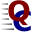
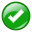
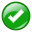
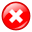
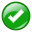
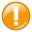
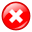
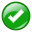
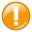
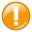
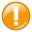
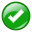
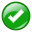
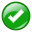
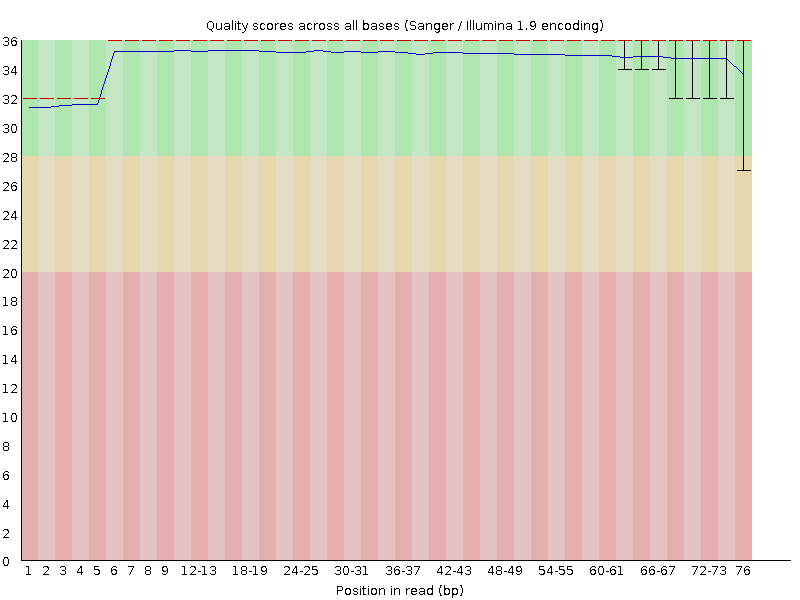
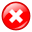
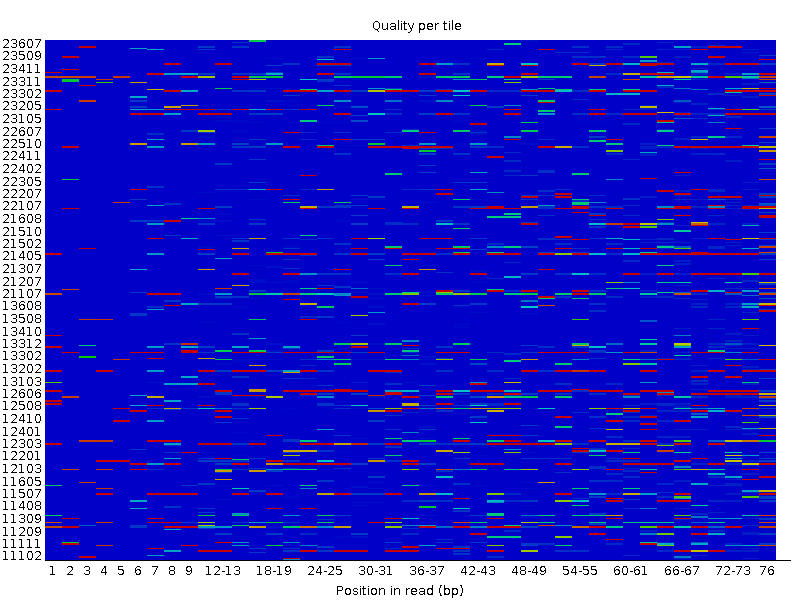
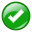
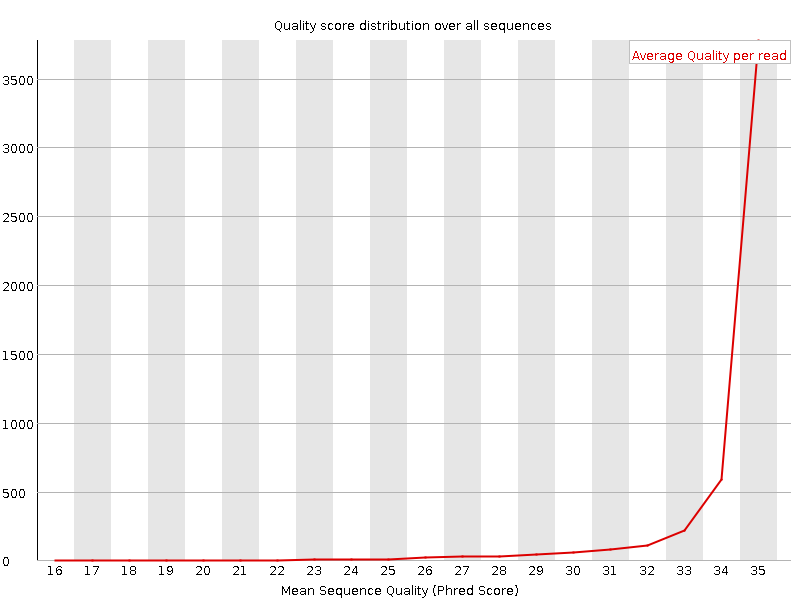
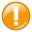
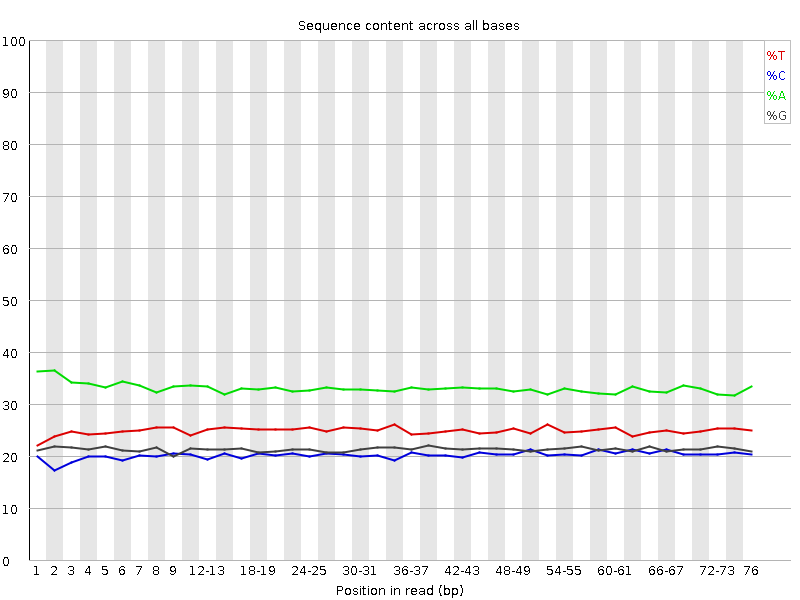
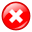
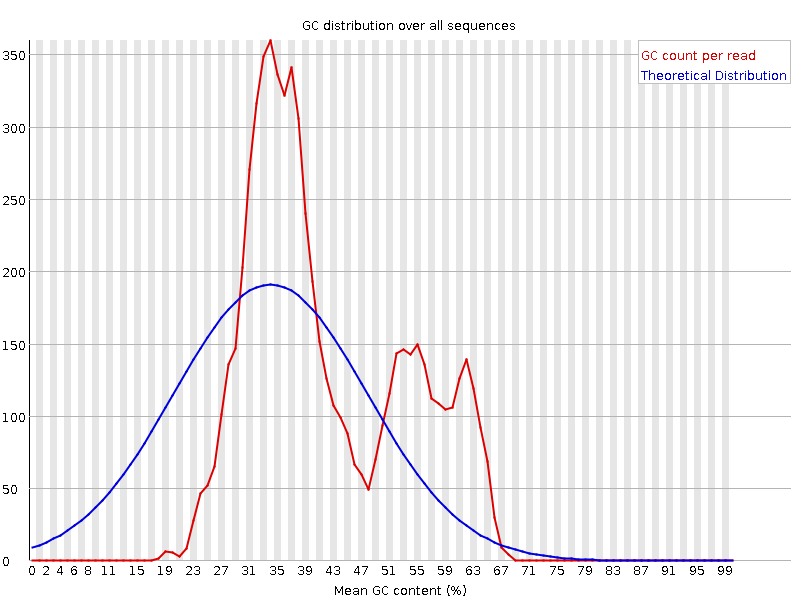
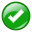
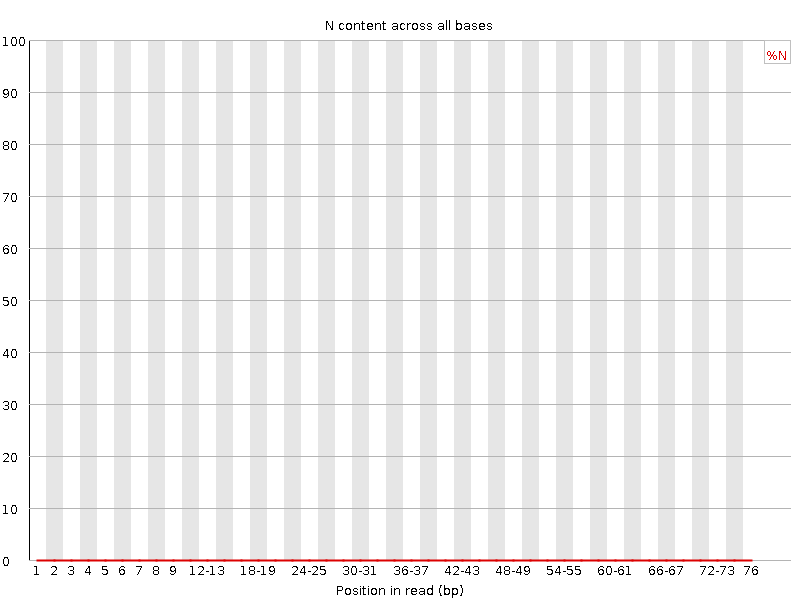
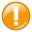
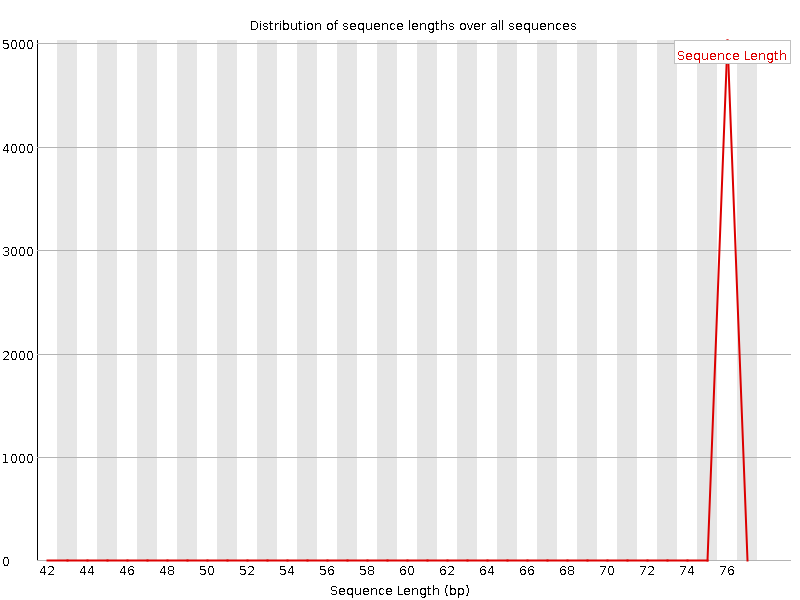
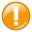
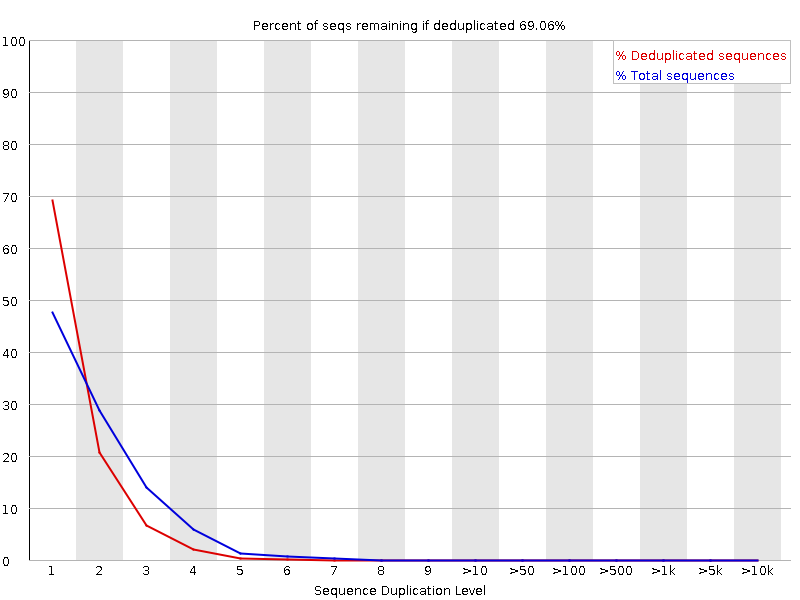
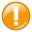
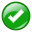
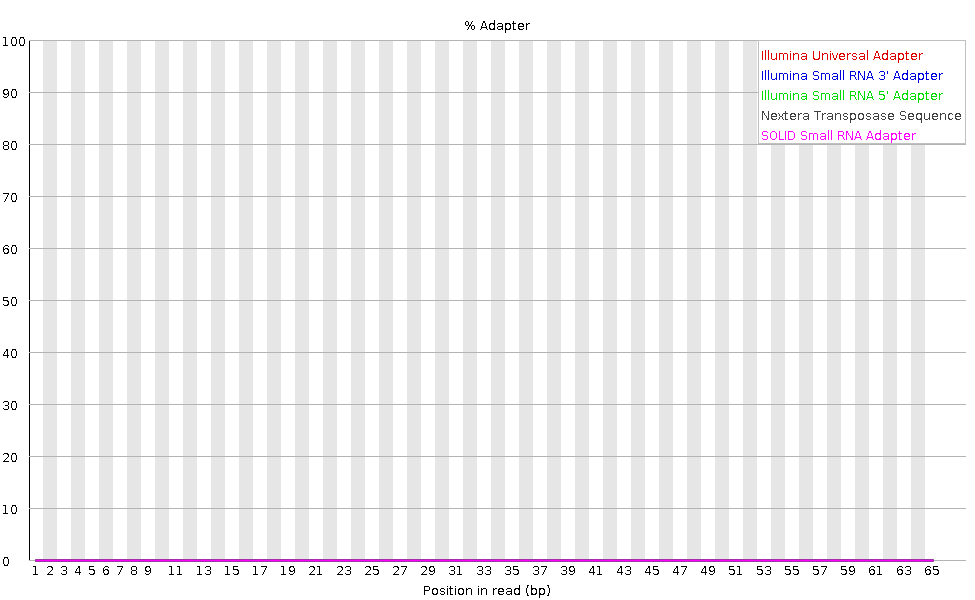

In [5]:
# 4. Display QC report in Colab
from IPython.core.display import display, HTML
with open('data/ngs_ws_hd701_R1_fastqc.html', 'r') as f:
    display(HTML(f.read()))

# Click the 3 vertical dots on the right of the **previous** cell and then click on view output fullscreen to see the QC file.

In [6]:
# 5. Align sequence to GRCh37

!bwa mem -M -v 1 -t 2 -R "@RG\\tID:hd701\\tSM:hd701\\tPL:ILLUMINA\\tPI:150\\tCN:lab" /content/assets/gatk_b37/hg19.p13.plusMT.no_alt_analysis_set.fa /content/data/hd701_R1_processed.fq.gz /content/data/hd701_R2_processed.fq.gz > /content/data/hd701_raw.sam

[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (144, 177, 224)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 384)
[M::mem_pestat] mean and std.dev: (186.75, 58.21)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 464)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[main] Version: 0.7.17-r1188
[main] CMD: bwa mem -M -v 1 -t 2 -R @RG\tID:hd701\tSM:hd701\tPL:ILLUMINA\tPI:150\tCN:lab /content/assets/gatk_b37/hg19.p13.plusMT.no_alt_analysis_set.fa /content/data/hd701_R1_processed.fq.gz /content/data/hd701_R2_processed.fq.gz
[main] Real time: 25.301 sec; CPU: 6.392 sec


In [7]:
# 6. Convert the SAM file into a BAM file
!samtools view -Shu data/hd701_raw.sam > data/hd701_raw.bam

In [8]:
# 7. Sort and index raw BAM file
!sambamba sort -p -t 2 -o data/hd701_sorted.bam data/hd701_raw.bam


sambamba 0.8.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2020
    LDC 1.10.0 / DMD v2.080.1 / LLVM6.0.1 / bootstrap LDC - the LLVM D compiler (0.17.4)

Writing sorted chunks to temporary directory...
[==============================================================================]


In [9]:
# 8. Mark PCR duplicates in BAM file
!sambamba markdup -t 2 -p data/hd701_sorted.bam data/hd701_dedup.bam


sambamba 0.8.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2020
    LDC 1.10.0 / DMD v2.080.1 / LLVM6.0.1 / bootstrap LDC - the LLVM D compiler (0.17.4)

finding positions of the duplicate reads in the file...
[==============================================================================]
  sorted 4959 end pairs
     and 0 single ends (among them 0 unmatched pairs)
  collecting indices of duplicate reads...   done in 2 ms
  found 860 duplicates
collected list of positions in 0 min 0 sec
marking duplicates...
[==============================================================================]
collected list of positions in 0 min 0 sec


In [10]:
# 9. Perform indel realignment - Update the reference path
!java -jar abra2-2.23.jar --in data/hd701_dedup.bam --out data/hd701_realigned.bam --ref /content/assets/gatk_b37/hg19.p13.plusMT.no_alt_analysis_set.fa \\
!--threads 2 --targets assets/ngs_ws.bed --index --tmpdir /tmp/ > data/hd701_abra.log

INFO	Thu May 01 21:16:47 UTC 2025	Abra version: 2.23
INFO	Thu May 01 21:16:47 UTC 2025	Abra params: [/content/abra2-2.23.jar --in data/hd701_dedup.bam --out data/hd701_realigned.bam --ref /content/assets/gatk_b37/hg19.p13.plusMT.no_alt_analysis_set.fa  !--threads 2 --targets assets/ngs_ws.bed --index --tmpdir /tmp/]
INFO	Thu May 01 21:16:47 UTC 2025	ABRA version: 2.23
INFO	Thu May 01 21:16:47 UTC 2025	input0: data/hd701_dedup.bam
INFO	Thu May 01 21:16:47 UTC 2025	output0: data/hd701_realigned.bam
INFO	Thu May 01 21:16:47 UTC 2025	regions: assets/ngs_ws.bed
INFO	Thu May 01 21:16:47 UTC 2025	reference: /content/assets/gatk_b37/hg19.p13.plusMT.no_alt_analysis_set.fa
INFO	Thu May 01 21:16:47 UTC 2025	num threads: 4
INFO	Thu May 01 21:16:47 UTC 2025	minEdgeFrequency: 0
minNodeFrequncy: 1
minContigLength: -1
minBaseQuality: 20
minReadCandidateFraction: 0.01
maxAverageRegionDepth: 1000
minEdgeRatio: 0.01

INFO	Thu May 01 21:16:47 UTC 2025	paired end: true
INFO	Thu May 01 21:16:47 UTC 2025	isS

In [11]:
# 10. Inspect aligned sequences (show first few lines)
!samtools view -h data/hd701_realigned.bam | head -n 20

@HD	VN:1.5	SO:coordinate
@SQ	SN:chr1	LN:249250621
@SQ	SN:chr2	LN:243199373
@SQ	SN:chr3	LN:198022430
@SQ	SN:chr4	LN:191154276
@SQ	SN:chr5	LN:180915260
@SQ	SN:chr6	LN:171115067
@SQ	SN:chr7	LN:159138663
@SQ	SN:chr8	LN:146364022
@SQ	SN:chr9	LN:141213431
@SQ	SN:chr10	LN:135534747
@SQ	SN:chr11	LN:135006516
@SQ	SN:chr12	LN:133851895
@SQ	SN:chr13	LN:115169878
@SQ	SN:chr14	LN:107349540
@SQ	SN:chr15	LN:102531392
@SQ	SN:chr16	LN:90354753
@SQ	SN:chr17	LN:81195210
@SQ	SN:chr18	LN:78077248
@SQ	SN:chr19	LN:59128983


In [12]:
!# 11. Call variant - Update the reference path
!samtools mpileup -BA -q 20 -Q 30 -d 4000 -l assets/ngs_ws.bed -f /content/assets/gatk_b37/hg19.p13.plusMT.no_alt_analysis_set.fa data/hd701_realigned.bam | java -Xmx4G -jar VarScan.v2.4.6.jar mpileup2vcf --min-coverage 8 --min-var-freq 0.05 --p-value 0.05 --min-avg-qual 30 --strand-filter 1 --output-vcf 1 --variants > data/hd701_raw.vcf

Only variants will be reported
Min coverage:	8
Min reads2:	2
Min var freq:	0.05
Min avg qual:	30
P-value thresh:	0.05
Input stream not ready, waiting for 5 seconds...
Input stream not ready, waiting for 5 seconds...
Input stream not ready, waiting for 5 seconds...
Input stream not ready, waiting for 5 seconds...
[mpileup] 1 samples in 1 input files
Reading input from STDIN
8078 bases in pileup file
14 variant positions (10 SNP, 4 indel)
0 were failed by the strand-filter
14 variant positions reported (10 SNP, 4 indel)


In [13]:
# 12. Compress and index VCF file
!bgzip data/hd701_raw.vcf
!tabix -p vcf data/hd701_raw.vcf.gz

In [14]:
# 13. Inspect variants in a raw VCF file
!zcat data/hd701_raw.vcf.gz | head -n 100

##fileformat=VCFv4.3
##source=VarScan2
##INFO=<ID=ADP,Number=1,Type=Integer,Description="Average per-sample depth of bases with Phred score >= 30">
##INFO=<ID=WT,Number=1,Type=Integer,Description="Number of samples called reference (wild-type)">
##INFO=<ID=HET,Number=1,Type=Integer,Description="Number of samples called heterozygous-variant">
##INFO=<ID=HOM,Number=1,Type=Integer,Description="Number of samples called homozygous-variant">
##INFO=<ID=NC,Number=1,Type=Integer,Description="Number of samples not called">
##FILTER=<ID=str10,Description="Less than 10% or more than 90% of variant supporting reads on one strand">
##FILTER=<ID=indelError,Description="Likely artifact due to indel reads at this position">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">
##FORMAT=<ID=SDP,Number=1,Type=Integer,Description="Raw Read Depth as reported by SAMtools">
##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Quality

In [15]:
# 14. Annotate variants (requires ANNOVAR to be set up)
!perl annovar/table_annovar.pl data/hd701_raw.vcf.gz assets/humandb/ -out data/hd701_annotated -buildver hg19 -remove -nastring . -otherinfo -vcfinput -thread 2 -maxgenethread 2 -protocol refGene,cytoBand,cosmic85,clinvar_20150330 -operation g,r,f,f

NOTICE: the --polish argument is set ON automatically (use --nopolish to change this behavior)

NOTICE: Running with system command <convert2annovar.pl  -includeinfo -allsample -withfreq -format vcf4 data/hd701_raw.vcf.gz > data/hd701_annotated.avinput>
NOTICE: Finished reading 38 lines from VCF file
NOTICE: A total of 14 locus in VCF file passed QC threshold, representing 10 SNPs (7 transitions and 3 transversions) and 4 indels/substitutions
NOTICE: Finished writing allele frequencies based on 10 SNP genotypes (7 transitions and 3 transversions) and 4 indels/substitutions for 1 samples

NOTICE: Running with system command <annovar/table_annovar.pl data/hd701_annotated.avinput assets/humandb/ -outfile data/hd701_annotated -buildver hg19 -remove -nastring . -otherinfo -thread 2 -maxgenethread 2 -protocol refGene,cytoBand,cosmic85,clinvar_20150330 -operation g,r,f,f -otherinfo>
NOTICE: the --polish argument is set ON automatically (use --nopolish to change this behavior)
----------------

In [16]:
# 15. Inspect annotated VCF file
!head -n 100 data/hd701_annotated.hg19_multianno.vcf

##fileformat=VCFv4.3
##source=VarScan2
##INFO=<ID=ADP,Number=1,Type=Integer,Description="Average per-sample depth of bases with Phred score >= 30">
##INFO=<ID=WT,Number=1,Type=Integer,Description="Number of samples called reference (wild-type)">
##INFO=<ID=HET,Number=1,Type=Integer,Description="Number of samples called heterozygous-variant">
##INFO=<ID=HOM,Number=1,Type=Integer,Description="Number of samples called homozygous-variant">
##INFO=<ID=NC,Number=1,Type=Integer,Description="Number of samples not called">
##FILTER=<ID=str10,Description="Less than 10% or more than 90% of variant supporting reads on one strand">
##FILTER=<ID=indelError,Description="Likely artifact due to indel reads at this position">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">
##FORMAT=<ID=SDP,Number=1,Type=Integer,Description="Raw Read Depth as reported by SAMtools">
##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Quality

In [17]:
# 16. 🌟 Download BAM files for visualization

from google.colab import files
files.download('data/hd701_realigned.bam') # Download the realigned bam file.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
files.download('data/hd701_realigned.bai') # Download the realigned bam index file.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>